# 2 Modeling

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
import math
import pickle 
from sklearn.metrics import mean_absolute_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, RepeatVector, Conv1D, Bidirectional
from helpers import *

# ignore warinings
import warnings
warnings.simplefilter("ignore")

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [17]:
train_dataset = pd.read_csv("./data_preprocessed/train_dataset.csv", index_col=0)
val_dataset = pd.read_csv("./data_preprocessed/val_dataset.csv", index_col=0)
test_dataset = pd.read_csv("./data_preprocessed/test_dataset.csv", index_col=0)

In [18]:
train_dataset.head()

,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,timestamp_9,timestamp_10,...,timestamp_132,timestamp_133,timestamp_134,timestamp_135,timestamp_136,timestamp_137,timestamp_138,timestamp_139,timestamp_140,label
90756.0,-2.864901,-0.472848,-2.939073,-0.417219,-2.883444,-0.287417,-2.827815,-0.139073,-2.809272,-0.064901,...,-4.237086,-2.698013,-4.274172,-2.753642,-4.311258,-2.698013,-4.274172,-2.660927,-4.218543,1
81771.0,-1.618182,-1.121212,-1.606061,-1.072727,-1.618182,-1.048485,-1.618182,-1.109091,-1.666667,-1.193939,...,-1.060606,-1.412121,-1.024242,-1.400000,-0.975758,-1.375758,-0.951515,-1.315152,-0.963636,1
95210.0,-0.753846,4.074359,-0.628205,5.169231,-0.664103,5.743590,-0.861538,5.635897,-1.202564,4.594872,...,-2.064103,-0.915385,-1.974359,-0.951282,-1.974359,-0.969231,-1.974359,-0.987179,-1.974359,1
11259.0,-1.868327,-1.204033,-1.951364,-1.204033,-1.951364,-1.187426,-1.967972,-1.120996,-1.901542,-1.071174,...,-1.021352,-0.888493,-1.004745,-0.905101,-1.071174,-0.888493,-1.054567,-0.755635,-1.037960,1
20148.0,-2.542005,-2.067751,-2.560976,-2.067751,-2.560976,-2.105691,-2.466125,-2.086721,-2.371274,-2.029810,...,-1.897019,-3.414634,-1.915989,-3.414634,-1.972900,-3.452575,-1.915989,-3.452575,-1.878049,1


In [19]:
X_train = np.array(train_dataset.drop(columns=['label']))
print(X_train.shape)

(500, 140)


In [20]:
X_val, y_val = np.array(val_dataset.drop(columns=['label'])), np.array(val_dataset['label'])
X_test, y_test = np.array(test_dataset.drop(columns=['label'])), np.array(test_dataset['label'])

print(X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(250, 140) (250,) (250, 140) (250,)


### Reshape feature set to desire format for LSTM (3d array)

In [21]:
# reshape to [num samples, num timesteps, num features]
X_train_3d = X_train.reshape(*X_train.shape,1)
X_val_3d = X_val.reshape(*X_val.shape,1)
X_test_3d = X_test.reshape(*X_test.shape,1)

print(X_train_3d.shape, X_val_3d.shape, X_test_3d.shape)

(500, 140, 1) (250, 140, 1) (250, 140, 1)


Note that the heartbeat records are in the range of about -7 to 7. In this case, data scalling is not necessary - I did not notice any improvement in models performance after data scalling.

In [22]:
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=0,
    verbose=1,
    patience=20,
    mode='min',
    baseline=None,
    restore_best_weights=True)

EPOCHS = 200
BATCH_SIZE = 32

# placeholder of predition metrics
results = Metrics()

### LSTM AutoEncoder

In [23]:
# Build model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_3d.shape[1:]) ) )
model.add(RepeatVector(X_train.shape[1]) )
model.add(LSTM(64, return_sequences=True) )
model.add(TimeDistributed(Dense(1) ) )
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 140, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 114: early stopping
Restoring model weights from the end of the best epoch: 94.


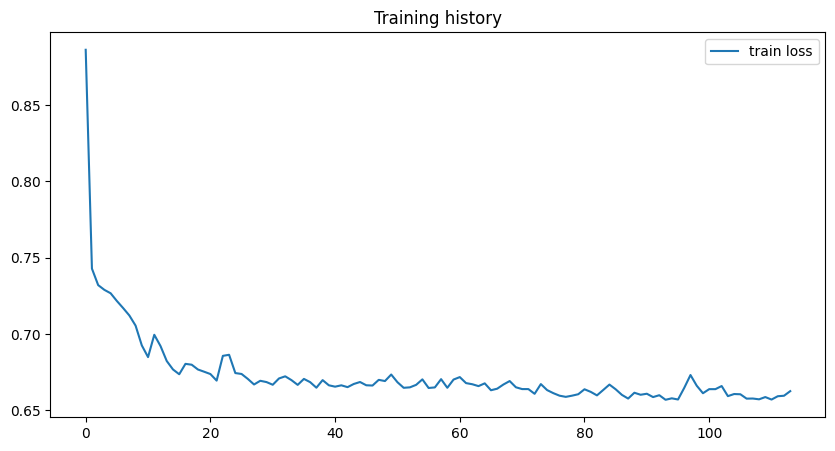

<Sequential name=sequential_1, built=True>

In [24]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<Axes: title={'center': 'Train reconstrucion losses distribution'}, ylabel='Density'>

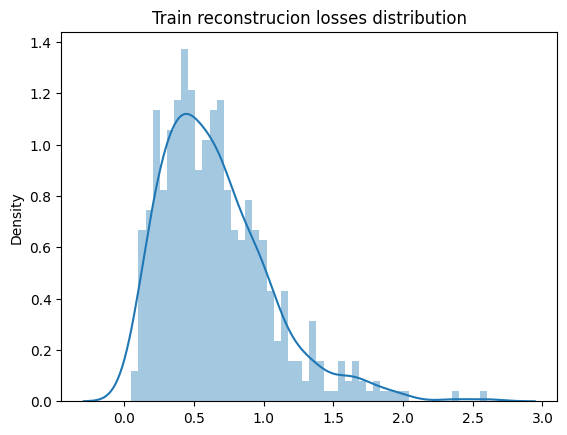

In [25]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [26]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 1.1488 Validation Accuracy: 0.904
Perentile:91 Threshold: 1.175 Validation Accuracy: 0.916
Perentile:92 Threshold: 1.2402 Validation Accuracy: 0.928
Perentile:93 Threshold: 1.2967 Validation Accuracy: 0.936
Perentile:94 Threshold: 1.3426 Validation Accuracy: 0.952
Perentile:95 Threshold: 1.4016 Validation Accuracy: 0.96
Perentile:96 Threshold: 1.566 Validation Accuracy: 0.968
Perentile:97 Threshold: 1.6141 Validation Accuracy: 0.968
Perentile:98 Threshold: 1.7109 Validation Accuracy: 0.976
Perentile:99 Threshold: 1.8591 Validation Accuracy: 0.984
-----------------------------------------------------------------
Best validation accuracy: 0.984 for threshold: 1.8591


In [27]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.992
Test recall score: 0.5082
Test f1 score: 0.6721
Test accuracy score: 0.516
Test auroc score: 0.516


### Stacked LSTM AutoEncoder

In [28]:
# Build model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_3d.shape[1:]), return_sequences=True))
model.add(LSTM(64))
model.add(RepeatVector(X_train_3d.shape[1]))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 140, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 140, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 140, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 165: early stopping
Restoring model weights from the end of the best epoch: 145.


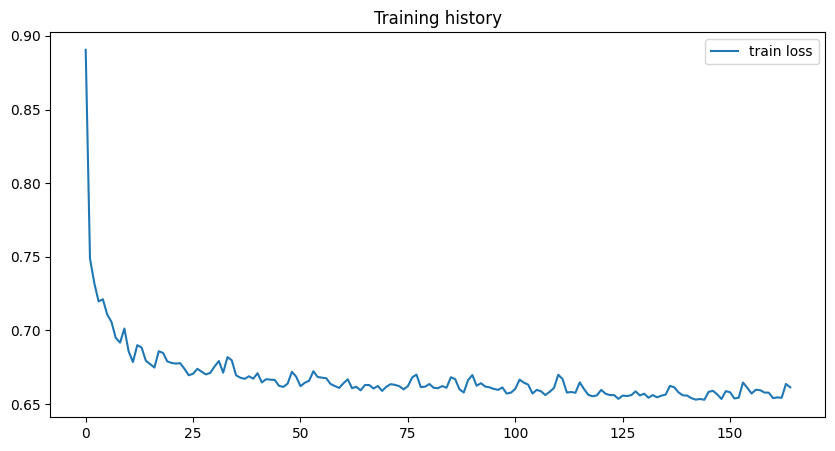

<Sequential name=sequential_2, built=True>

In [29]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


<Axes: title={'center': 'Train reconstrucion losses distribution'}, ylabel='Density'>

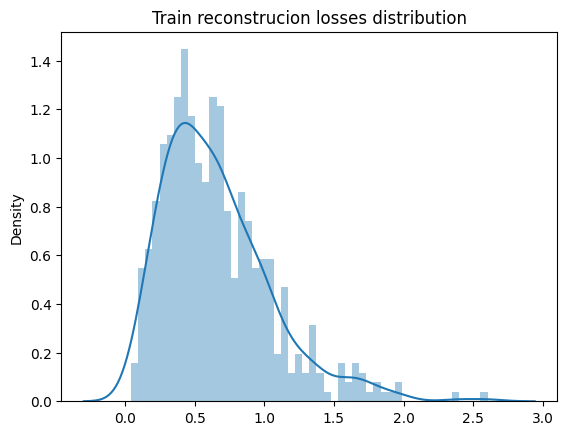

In [30]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [31]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 1.149 Validation Accuracy: 0.908
Perentile:91 Threshold: 1.1675 Validation Accuracy: 0.92
Perentile:92 Threshold: 1.2406 Validation Accuracy: 0.932
Perentile:93 Threshold: 1.2965 Validation Accuracy: 0.94
Perentile:94 Threshold: 1.3416 Validation Accuracy: 0.948
Perentile:95 Threshold: 1.3814 Validation Accuracy: 0.956
Perentile:96 Threshold: 1.5422 Validation Accuracy: 0.968
Perentile:97 Threshold: 1.6319 Validation Accuracy: 0.972
Perentile:98 Threshold: 1.7103 Validation Accuracy: 0.976
Perentile:99 Threshold: 1.8362 Validation Accuracy: 0.984
-----------------------------------------------------------------
Best validation accuracy: 0.984 for threshold: 1.8362


In [32]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Stacked LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.984
Test recall score: 0.5062
Test f1 score: 0.6685
Test accuracy score: 0.512
Test auroc score: 0.512


### CNN LSTM AutoEncoder

In [33]:
# Build model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_3d.shape[1:]) ) ) 
model.add(LSTM(64) )
model.add(RepeatVector(X_train_3d.shape[1]) )
model.add(LSTM(64, return_sequences=True) )
model.add(TimeDistributed(Dense(1) ) )
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 138, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 140, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,369 (259.25 KB)

 Trainable params: 66,369 (259.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 141: early stopping
Restoring model weights from the end of the best epoch: 121.


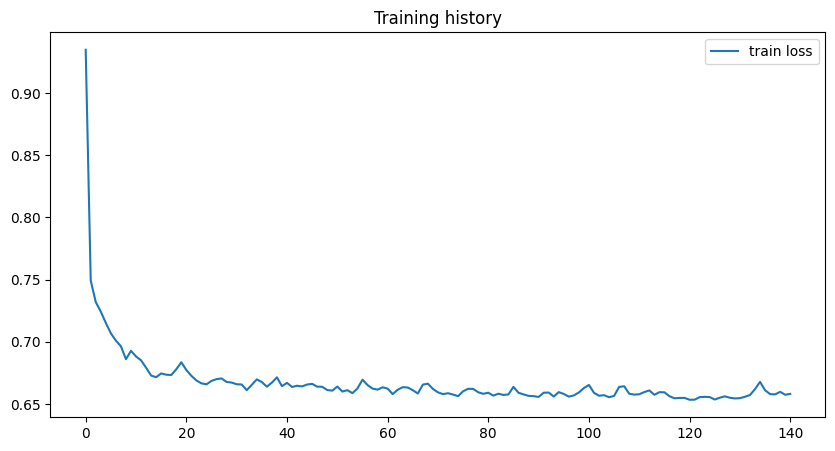

<Sequential name=sequential_3, built=True>

In [34]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Axes: title={'center': 'Train reconstrucion losses distribution'}, ylabel='Density'>

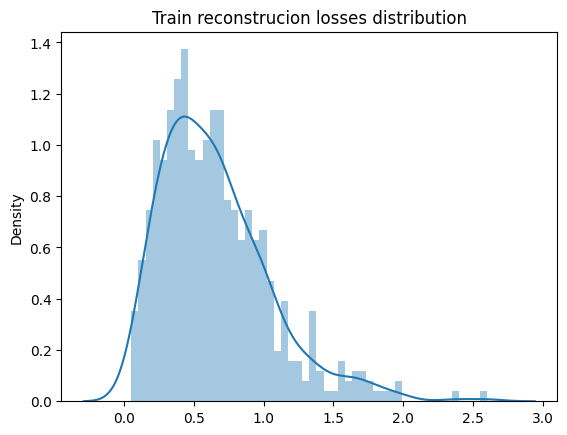

In [35]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [36]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 1.1478 Validation Accuracy: 0.904
Perentile:91 Threshold: 1.1662 Validation Accuracy: 0.912
Perentile:92 Threshold: 1.2393 Validation Accuracy: 0.928
Perentile:93 Threshold: 1.2973 Validation Accuracy: 0.936
Perentile:94 Threshold: 1.3402 Validation Accuracy: 0.948
Perentile:95 Threshold: 1.3842 Validation Accuracy: 0.956
Perentile:96 Threshold: 1.5398 Validation Accuracy: 0.968
Perentile:97 Threshold: 1.6206 Validation Accuracy: 0.968
Perentile:98 Threshold: 1.7165 Validation Accuracy: 0.976
Perentile:99 Threshold: 1.8391 Validation Accuracy: 0.984
-----------------------------------------------------------------
Best validation accuracy: 0.984 for threshold: 1.8391


In [37]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('CNN LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.984
Test recall score: 0.5062
Test f1 score: 0.6685
Test accuracy score: 0.512
Test auroc score: 0.512


### Bidirectional LSTM AutoEncoder

In [38]:
# Build model
model = Sequential()
model.add(Bidirectional(LSTM(64), input_shape=(X_train_3d.shape[1:]) ) )
model.add(RepeatVector(X_train_3d.shape[1]))
model.add(Bidirectional(LSTM(64, return_sequences=True) ) )
model.add(TimeDistributed(Dense(1)) )
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 140, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 140, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 140, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,737 (518.50 KB)

 Trainable params: 132,737 (518.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 188: early stopping
Restoring model weights from the end of the best epoch: 168.


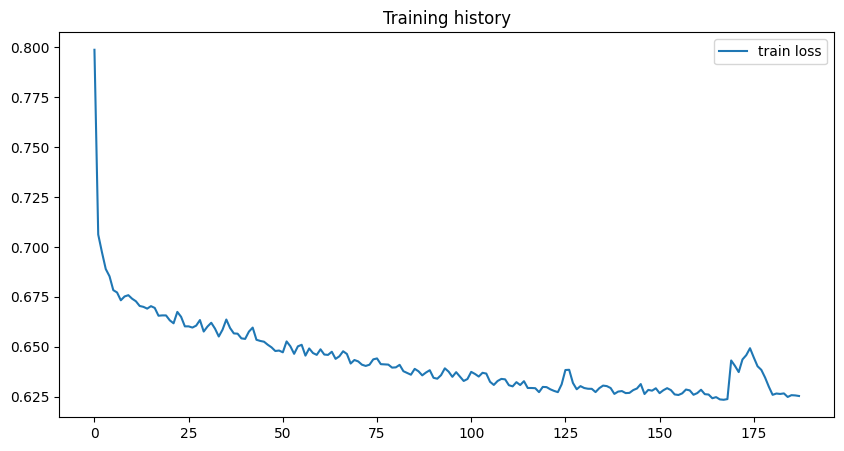

<Sequential name=sequential_4, built=True>

In [39]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


<Axes: title={'center': 'Train reconstrucion losses distribution'}, ylabel='Density'>

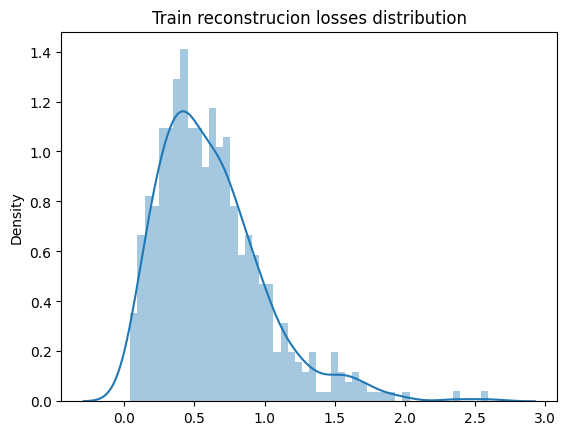

In [40]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [41]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 1.1071 Validation Accuracy: 0.904
Perentile:91 Threshold: 1.1359 Validation Accuracy: 0.908
Perentile:92 Threshold: 1.1836 Validation Accuracy: 0.924
Perentile:93 Threshold: 1.2189 Validation Accuracy: 0.932
Perentile:94 Threshold: 1.2927 Validation Accuracy: 0.944
Perentile:95 Threshold: 1.3417 Validation Accuracy: 0.952
Perentile:96 Threshold: 1.514 Validation Accuracy: 0.964
Perentile:97 Threshold: 1.5431 Validation Accuracy: 0.964
Perentile:98 Threshold: 1.6487 Validation Accuracy: 0.968
Perentile:99 Threshold: 1.788 Validation Accuracy: 0.984
-----------------------------------------------------------------
Best validation accuracy: 0.984 for threshold: 1.788


In [42]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Bidirectional LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.984
Test recall score: 0.5062
Test f1 score: 0.6685
Test accuracy score: 0.512
Test auroc score: 0.512


### Inception LSTM AutoEncoder

In [43]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model

def inception_module(x, filters):
    conv1x1 = Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(x)
    conv3x3 = Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    conv5x5 = Conv1D(filters=filters, kernel_size=5, padding='same', activation='relu')(x)
    
    maxpool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    maxpool_conv = Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(maxpool)
    
    concatenated = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool_conv])
    return concatenated

input_shape = X_train_3d.shape[1:]
input_layer = Input(shape=input_shape)
x = inception_module(input_layer, filters=64)
x = LSTM(64)(x)
x = RepeatVector(X_train_3d.shape[1])(x)
x = LSTM(64, return_sequences=True)(x)
x = TimeDistributed(Dense(1))(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 140, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 140, 1)    │          0 │ input_layer_5[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 140, 64)   │        128 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 140, 64)   │        256 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 140, 64)   │        384 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 140, 64)   │        128 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 140, 256)  │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 64)        │     82,176 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 140, 64)   │          0 │ lstm_12[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 140, 64)   │     33,024 │ repeat_vector_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 140, 1)    │         65 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 116,161 (453.75 KB)

 Trainable params: 116,161 (453.75 KB)

 Non-trainable params: 0 (0.00 B)

Restoring model weights from the end of the best epoch: 196.


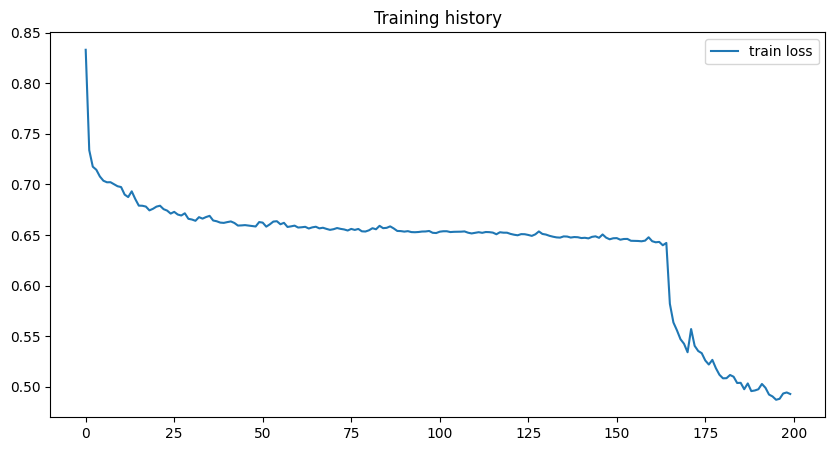

<Functional name=functional_23, built=True>

In [44]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


<Axes: title={'center': 'Train reconstrucion losses distribution'}, ylabel='Density'>

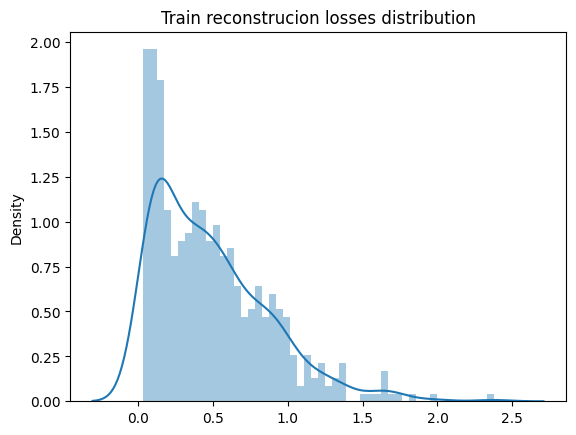

In [45]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True)

In [46]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.9794 Validation Accuracy: 0.9
Perentile:91 Threshold: 1.0117 Validation Accuracy: 0.908
Perentile:92 Threshold: 1.0395 Validation Accuracy: 0.912
Perentile:93 Threshold: 1.1113 Validation Accuracy: 0.92
Perentile:94 Threshold: 1.1498 Validation Accuracy: 0.92
Perentile:95 Threshold: 1.2151 Validation Accuracy: 0.94
Perentile:96 Threshold: 1.269 Validation Accuracy: 0.944
Perentile:97 Threshold: 1.3496 Validation Accuracy: 0.96
Perentile:98 Threshold: 1.5661 Validation Accuracy: 0.976
Perentile:99 Threshold: 1.6675 Validation Accuracy: 0.984
-----------------------------------------------------------------
Best validation accuracy: 0.984 for threshold: 1.6675


In [47]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score, test_auroc = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Bidirectional LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score, test_auroc)

Test precision score: 0.984
Test recall score: 0.5041
Test f1 score: 0.6667
Test accuracy score: 0.508
Test auroc score: 0.508


## Show all result in one table and save it for future purpose

In [48]:
# get prediction metric result lists from placeholder
precision_score, recall_score, f1_score, accuracy_score,auroc = results.get_metrics()

# get model names list from placeholder
models_name = results.get_names()

# create dictionary of results 
results_dict = {'precision_score': precision_score, 
               'recall_score': recall_score, 
               'f1_score': f1_score,
               'accuracy_score' : accuracy_score,
               'AUROC' : auroc}

results_df = pd.DataFrame(data=results_dict)
results_df.insert(loc=0, column='Model', value=models_name)
results_df

,Model,precision_score,recall_score,f1_score,accuracy_score,AUROC
0,LSTM AutoEncoder,0.992,0.508197,0.672087,0.516,0.516
1,Stacked LSTM AutoEncoder,0.984,0.506173,0.668478,0.512,0.512
2,CNN LSTM AutoEncoder,0.984,0.506173,0.668478,0.512,0.512
3,Bidirectional LSTM AutoEncoder,0.984,0.506173,0.668478,0.512,0.512
4,Bidirectional LSTM AutoEncoder,0.984,0.504098,0.666667,0.508,0.508


In [49]:
# save metrics
results_df.to_csv('./results/final_results.csv')

# save model names
with open('./results/models_name.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(models_name, f, pickle.HIGHEST_PROTOCOL)

# extract reconstructed test sequences and predictions from placeholder
test_sequences, test_predictions = results.get_test_predictions()

# save test sequences
with open('./results/test_sequences.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(test_sequences, f, pickle.HIGHEST_PROTOCOL)

# save test predictions
with open('./results/test_predictions.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(test_predictions, f, pickle.HIGHEST_PROTOCOL)